In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


plt.style.use("default")

START_DATE = "1990-01-01"
END_DATE   = datetime.today().strftime("%Y-%m-%d")

FRED_SERIES = "BAMLH0A0HYM2"  # HY Option-Adjusted Spread (bps)

LGD = 0.60
WINDOW = 250  


/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#Download of the time series  
hy_oas = pdr.DataReader(FRED_SERIES, "fred", START_DATE, END_DATE)
hy_oas = hy_oas.dropna()
hy_oas.columns = ["HY_OAS_bps"]


hy_oas["HY_OAS_bps"] = hy_oas["HY_OAS_bps"]*100.0

hy_oas.tail()


,HY_OAS_bps
DATE,
2025-11-30,292.0
2025-12-01,294.0
2025-12-02,292.0
2025-12-03,289.0
2025-12-04,288.0


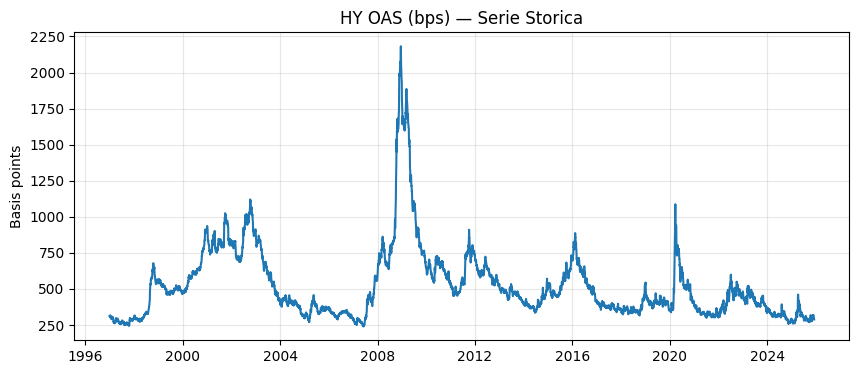

In [3]:
#Graphic representation of the time series
plt.figure(figsize=(10,4))
plt.plot(hy_oas.index, hy_oas["HY_OAS_bps"])
plt.title("HY OAS (bps) — Serie Storica")
plt.ylabel("Basis points")
plt.grid(alpha=0.3)
plt.show()


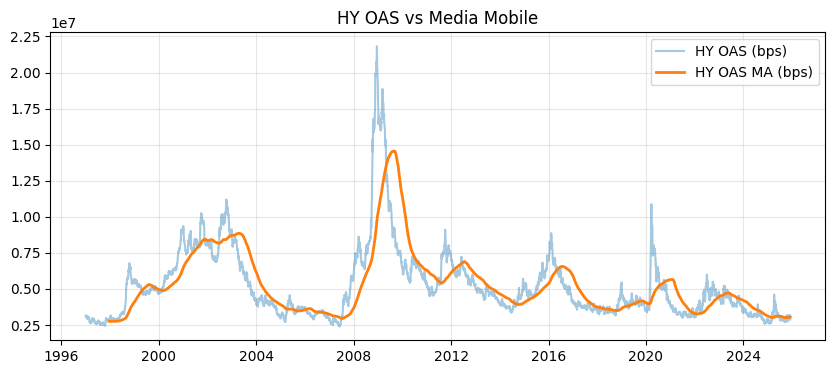

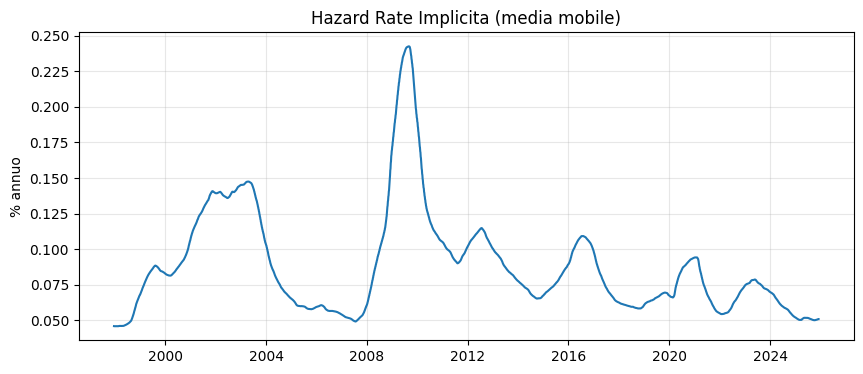

In [4]:
# Moviaing Average calculation for smoothing the series  
hy_oas["HY_OAS_MA"] = hy_oas["HY_OAS_bps"].rolling(WINDOW).mean()

# Hazard rate implicita (approx): lambda = s / LGD
hy_oas["lambda_base"] = (hy_oas["HY_OAS_MA"]/10000) / LGD

# Grafici
plt.figure(figsize=(10,4))
plt.plot(hy_oas.index, hy_oas["HY_OAS_bps"]*1e4, alpha=0.4, label="HY OAS (bps)")
plt.plot(hy_oas.index, hy_oas["HY_OAS_MA"]*1e4, label="HY OAS MA (bps)", linewidth=2)
plt.title("HY OAS vs Media Mobile")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(hy_oas.index, hy_oas["lambda_base"])
plt.title("Hazard Rate Implicita (media mobile)")
plt.ylabel("% annuo")
plt.grid(alpha=0.3)
plt.show()


In [5]:
# Data Processing IPCC Scenarios
IPCC_CSV_PATH = "/Users/emanuelemigliaccio/Climate-Risk-Project/data/owid_ipcc_scenarios.csv"

df_ssp_raw = pd.read_csv(IPCC_CSV_PATH)

SELECTED_SCENARIOS = ["SSP1 - 1.9", "SSP2 - 4.5", "SSP5 - 6.0"]
df_ssp = df_ssp_raw[df_ssp_raw["Scenario"].isin(SELECTED_SCENARIOS)].copy()

YEAR_MIN, YEAR_MAX = 2000, 2100
df_ssp = df_ssp[(df_ssp["Year"] >= YEAR_MIN) & (df_ssp["Year"] <= YEAR_MAX)].copy()

numeric_cols = df_ssp.select_dtypes(include=[np.number]).columns.tolist()
if "Year" in numeric_cols:
    numeric_cols.remove("Year")

df_ssp = df_ssp.sort_values(["Scenario", "Year"]).reset_index(drop=True)

# Interpolation for each scenario
df_list = []

for scen, g in df_ssp.groupby("Scenario"):
    
    g = g.set_index("Year")
    
    full_years = pd.Index(range(YEAR_MIN, YEAR_MAX + 1), name="Year")
    g = g.reindex(full_years)
    
    g[numeric_cols] = g[numeric_cols].interpolate(method="linear")
    
    g[numeric_cols] = g[numeric_cols].ffill().bfill()
    
    g["Scenario"] = scen
    
    df_list.append(g.reset_index())

df_ssp_interp = pd.concat(df_list, ignore_index=True)

df_ssp_interp.head(20)


,Year,Scenario,Crop demand,Energy crop demand,Livestock demand,Energy crop production,Non-energy crop production,Livestock production,Carbon price,Methane concentration,...,Carbon intensity of energy,Primary energy intensity,Final energy intensity,Final energy as a share of primary energy,final_energy_biomass,final_energy_coal,final_energy_solar,annotation,primary_energy_intensity,final_energy_intensity
0,2000,SSP1 - 1.9,3.389947e+09,NaN,2.389865e+08,3.146967e+07,3.417340e+09,2.389865e+08,0.0,1753.16000,...,0.260113,2.221063,1.648901,74.239293,37.993250,31.626500,0.016459,NaN,0.007996,0.005936
1,2001,SSP1 - 1.9,3.389947e+09,NaN,2.389865e+08,3.146967e+07,3.417340e+09,2.389865e+08,0.0,1753.16000,...,0.260113,2.221063,1.648901,74.239293,37.993250,31.626500,0.016459,NaN,0.007996,0.005936
2,2002,SSP1 - 1.9,3.389947e+09,NaN,2.389865e+08,3.146967e+07,3.417340e+09,2.389865e+08,0.0,1753.16000,...,0.260113,2.221063,1.648901,74.239293,37.993250,31.626500,0.016459,NaN,0.007996,0.005936
3,2003,SSP1 - 1.9,3.389947e+09,NaN,2.389865e+08,3.146967e+07,3.417340e+09,2.389865e+08,0.0,1753.16000,...,0.260113,2.221063,1.648901,74.239293,37.993250,31.626500,0.016459,NaN,0.007996,0.005936
4,2004,SSP1 - 1.9,3.389947e+09,NaN,2.389865e+08,3.146967e+07,3.417340e+09,2.389865e+08,0.0,1753.16000,...,0.260113,2.221063,1.648901,74.239293,37.993250,31.626500,0.016459,NaN,0.007996,0.005936
5,2005,SSP1 - 1.9,3.389947e+09,NaN,2.389865e+08,3.146967e+07,3.417340e+09,2.389865e+08,0.0,1753.16000,...,0.260113,2.221063,1.648901,74.239293,37.993250,31.626500,0.016459,Sustainability - Taking the Green Road,0.007996,0.005936
6,2006,SSP1 - 1.9,3.467989e+09,NaN,2.436773e+08,3.638354e+07,3.496545e+09,2.436774e+08,0.0,1765.10080,...,0.258600,2.187365,1.617163,73.911847,39.146056,33.231732,0.037450,NaN,0.007875,0.005822
7,2007,SSP1 - 1.9,3.546032e+09,NaN,2.483682e+08,4.129741e+07,3.575751e+09,2.483682e+08,0.0,1777.04160,...,0.257087,2.153667,1.585425,73.584401,40.298861,34.836964,0.058441,NaN,0.007753,0.005708
8,2008,SSP1 - 1.9,3.624074e+09,NaN,2.530590e+08,4.621129e+07,3.654956e+09,2.530591e+08,0.0,1788.98240,...,0.255574,2.119968,1.553686,73.256955,41.451667,36.442196,0.079432,NaN,0.007632,0.005593
9,2009,SSP1 - 1.9,3.702117e+09,NaN,2.577499e+08,5.112516e+07,3.734162e+09,2.577499e+08,0.0,1800.92320,...,0.254061,2.086270,1.521948,72.929509,42.604473,38.047428,0.100423,NaN,0.007511,0.005479


In [6]:
TEMP_COL = "Temperature"
CARBON_COL = "CO2 emissions"
RENEW_COL = "Primary energy (%, solar)"

df_ssp = df_ssp_interp.sort_values(["Scenario", "Year"]).reset_index(drop=True)

def z(x):
    return (x - x.mean()) / x.std(ddof=0)

df_ssp["z_temp"]   = df_ssp.groupby("Scenario")[TEMP_COL].transform(z)
df_ssp["z_carbon"] = df_ssp.groupby("Scenario")[CARBON_COL].transform(z)
df_ssp["z_renew"]  = df_ssp.groupby("Scenario")[RENEW_COL].transform(z)

df_ssp["CPI"] = np.nan

df_ssp_pulito = df_ssp[["Scenario", "Year", "z_temp", "z_carbon", "z_renew"]].copy()

df_ssp_pulito.head()


,Scenario,Year,z_temp,z_carbon,z_renew
0,SSP1 - 1.9,2000,-2.334243,1.494024,-1.271499
1,SSP1 - 1.9,2001,-2.334243,1.494024,-1.271499
2,SSP1 - 1.9,2002,-2.334243,1.494024,-1.271499
3,SSP1 - 1.9,2003,-2.334243,1.494024,-1.271499
4,SSP1 - 1.9,2004,-2.334243,1.494024,-1.271499


In [7]:
# Calculation of historical CPI
# We take the SSP part that coincides with our HY OAS years

hy_annual = hy_oas['lambda_base'].resample('YE').mean()
hy_annual = hy_annual.to_frame().reset_index()
hy_annual = hy_annual.rename(columns={'DATE': 'Year'})
hy_annual['Year'] = hy_annual['Year'].dt.year
df_ssp_pulito['Year'] = df_ssp_pulito['Year'].astype(int)



df = pd.merge(df_ssp_pulito,hy_annual, on='Year', how='left')


df.head()


,Scenario,Year,z_temp,z_carbon,z_renew,lambda_base
0,SSP1 - 1.9,2000,-2.334243,1.494024,-1.271499,0.088859
1,SSP1 - 1.9,2001,-2.334243,1.494024,-1.271499,0.127437
2,SSP1 - 1.9,2002,-2.334243,1.494024,-1.271499,0.139651
3,SSP1 - 1.9,2003,-2.334243,1.494024,-1.271499,0.134581
4,SSP1 - 1.9,2004,-2.334243,1.494024,-1.271499,0.078711


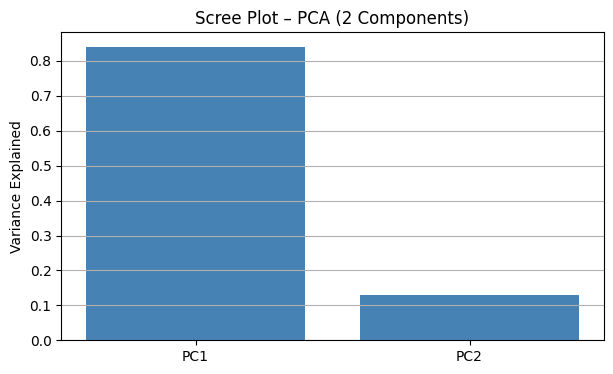

=== Diagnostica quantitativa ===
R²:   0.1847
MAE:  0.2397
RMSE: 0.3136



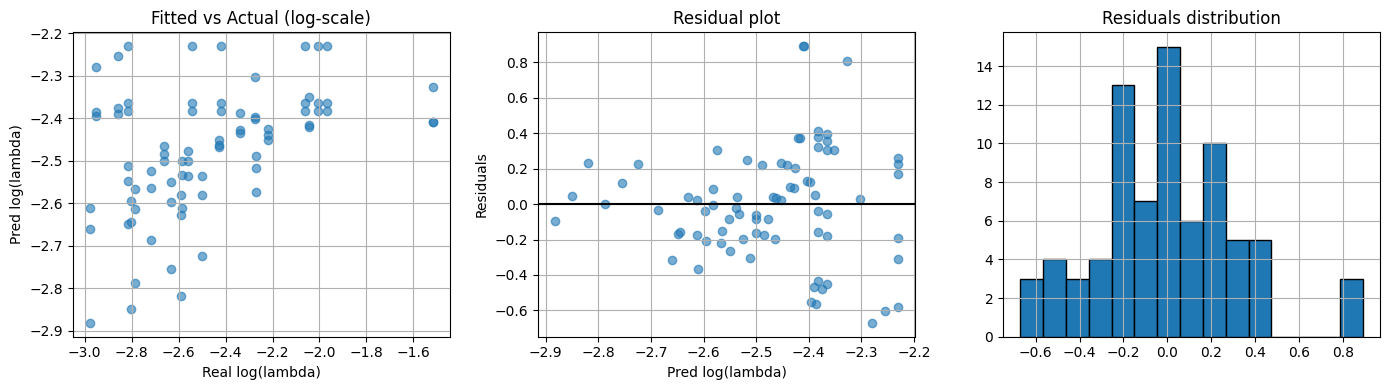

In [8]:
df_wo_nan = df.dropna(subset=["lambda_base", "z_temp", "z_carbon", "z_renew"]).copy()
X = df_wo_nan[["z_temp", "z_carbon", "z_renew"]].values
y = df_wo_nan["lambda_base"].values


pca = PCA(n_components=2)
climate_pc = pca.fit_transform(X)


plt.figure(figsize=(7,4))
plt.bar([1,2], pca.explained_variance_ratio_, color="steelblue")
plt.xticks([1,2], ["PC1","PC2"])
plt.ylabel("Variance Explained")
plt.title("Scree Plot – PCA (2 Components)")
plt.grid(axis="y")
plt.show()




# Log-hazard
eps = 1e-6
y_log = np.log(y + eps)


#ridge regression

reg = Ridge(alpha=0.2)
reg.fit(climate_pc, y_log)

beta0 = reg.intercept_
beta = reg.coef_


y_log_pred = reg.predict(climate_pc)

# Diagnostic 

r2 = r2_score(y_log, y_log_pred)
mae = mean_absolute_error(y_log, y_log_pred)
rmse = np.sqrt(mean_squared_error(y_log, y_log_pred))

print("=== Diagnostica quantitativa ===")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print()


import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.scatter(y_log, y_log_pred, alpha=0.6)
plt.xlabel("Real log(lambda)")
plt.ylabel("Pred log(lambda)")
plt.title("Fitted vs Actual (log-scale)")
plt.grid(True)


residuals = y_log - y_log_pred

plt.subplot(1,3,2)
plt.scatter(y_log_pred, residuals, alpha=0.6)
plt.axhline(0, c='black')
plt.xlabel("Pred log(lambda)")
plt.ylabel("Residuals")
plt.title("Residual plot")
plt.grid(True)

plt.subplot(1,3,3)
plt.hist(residuals, bins=15, edgecolor="black")
plt.title("Residuals distribution")
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
df_wo_nan['Climate_PC1'] = climate_pc[:, 0]
df_wo_nan['Climate_PC2'] = climate_pc[:, 1]

In [10]:
#  Defining a non-climatic baseline
Z_ref = df_wo_nan[["Climate_PC1", "Climate_PC2"]].mean().values

X_s = df_wo_nan[["Climate_PC1", "Climate_PC2"]].values

delta_log = (X_s - Z_ref) @ beta.T
multiplier = np.exp(delta_log)  # moltiplicatore > 0
df_wo_nan['climate_multiplier'] = multiplier


In [11]:
df_wo_nan['lambda_future'] = df_wo_nan['lambda_base'] * df_wo_nan['climate_multiplier']

In [12]:
df_plot = df_wo_nan[(df_wo_nan["Year"] >= 2005) & (df_wo_nan["Year"] <= 2025)]



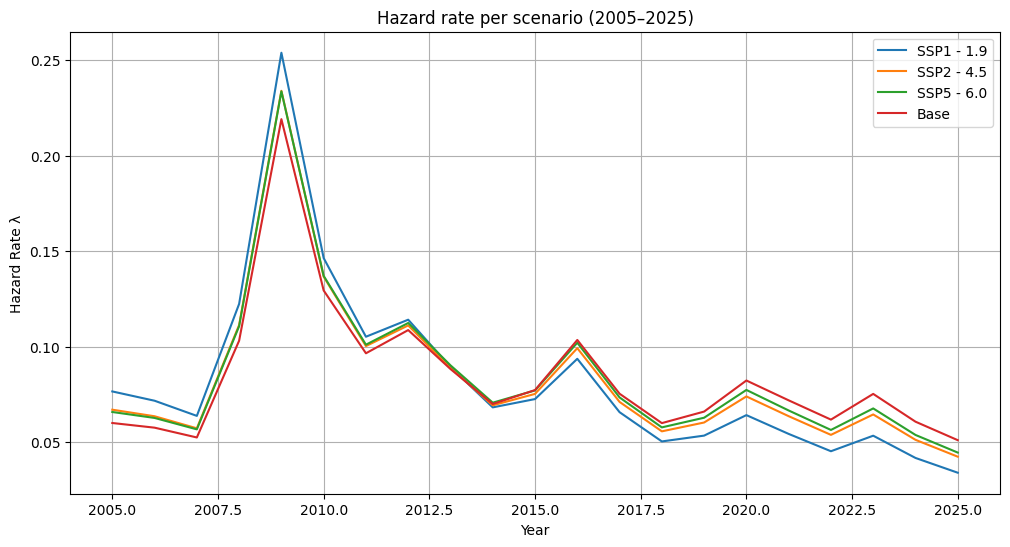

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for scen in df_plot["Scenario"].unique():
    df_s = df_plot[df_plot["Scenario"] == scen]
    plt.plot(df_s["Year"], df_s["lambda_future"], label=scen)

plt.plot(df_s["Year"], df_s["lambda_base"], label="Base")

plt.xlabel("Year")
plt.ylabel("Hazard Rate λ")
plt.title("Hazard rate per scenario (2005–2025)")
plt.legend()
plt.grid(True)
plt.show()


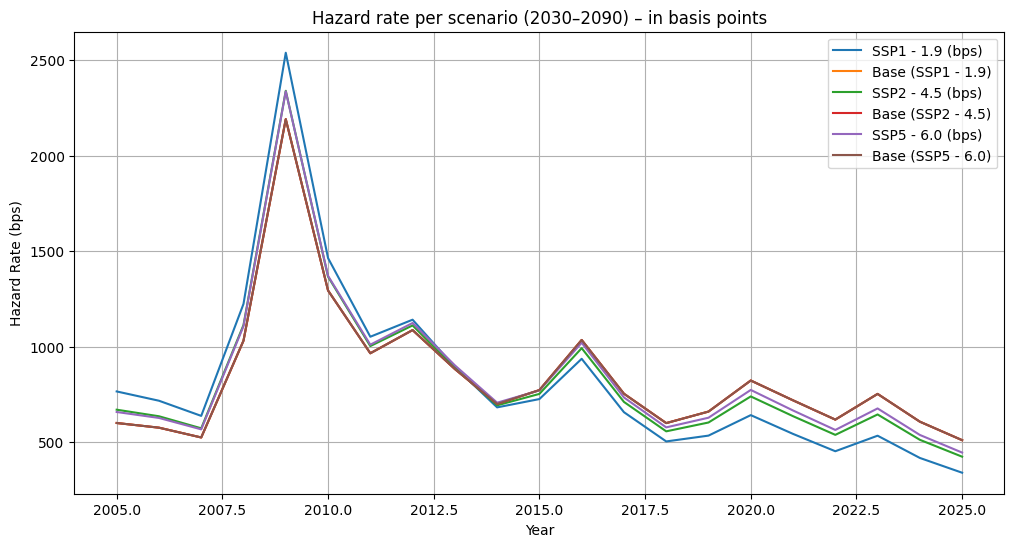

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for scen in df_plot["Scenario"].unique():
    df_s = df_plot[df_plot["Scenario"] == scen]

    # Curve future
    plt.plot(
        df_s["Year"],
        df_s["lambda_future"] * 10000,
        label=f"{scen} (bps)"
    )

    # Baseline
    plt.plot(
        df_s["Year"],
        df_s["lambda_base"] * 10000,
        label=f"Base ({scen})"
    )

plt.xlabel("Year")
plt.ylabel("Hazard Rate (bps)")
plt.title("Hazard rate per scenario (2030–2090) – in basis points")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
yield_forecast = pd.read_csv('/Users/emanuelemigliaccio/Climate-Risk-Project/data/yield_forecasting.csv')

In [ ]:
pca_2 = PCA(n_components=2)
climate_pc_tot = pca_2.fit_transform(df_ssp_pulito[["z_temp", "z_carbon", "z_renew"]].values)


In [ ]:
pca_2.explained_variance_ratio_

array([0.72164763, 0.23046876])

In [23]:
yield_forecast.iloc[:,0].values


array([2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100])

In [ ]:
from scipy.interpolate import PchipInterpolator

years = yield_forecast.iloc[:,0].values

years_new = range(years.min(), years.max() + 1)

df_interp_phi = pd.DataFrame(index=years_new)

for col in yield_forecast.columns:
    y = yield_forecast[col].values
    
    f = PchipInterpolator(years, y)
    
    df_interp_phi[col] = f(years_new)

df_interp_phi


,Unnamed: 0,1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0
2010,2010.0,5.743613,6.165274,6.208482,6.070942,5.946138,5.836089,5.703365,5.659058
2011,2011.0,5.560510,5.972758,6.027681,5.917638,5.811691,5.717405,5.603361,5.565255
2012,2012.0,5.382152,5.785884,5.851851,5.767544,5.680408,5.601915,5.506409,5.474405
2013,2013.0,5.211961,5.608096,5.684305,5.623704,5.554675,5.491426,5.413699,5.387517
2014,2014.0,5.053360,5.442839,5.528353,5.489164,5.436877,5.387744,5.326425,5.305599
...,...,...,...,...,...,...,...,...,...
2096,2096.0,2.453399,2.666147,2.977359,3.465519,3.752624,3.985764,4.262280,4.354553
2097,2097.0,2.427610,2.637368,2.951569,3.447053,3.739028,3.976232,4.257587,4.351463
2098,2098.0,2.403363,2.610340,2.927332,3.429648,3.726165,3.967160,4.253030,4.348401
2099,2099.0,2.380755,2.585175,2.904746,3.413370,3.714080,3.958575,4.248613,4.345367


In [25]:
df_interp_phi.columns

Index(['Unnamed: 0', '1.0', '2.0', '3.0', '5.0', '7.0', '10.0', '20.0',
       '30.0'],
      dtype='object')

In [26]:
df_interp_phi = df_interp_phi.drop(columns=["Unnamed: 0"])


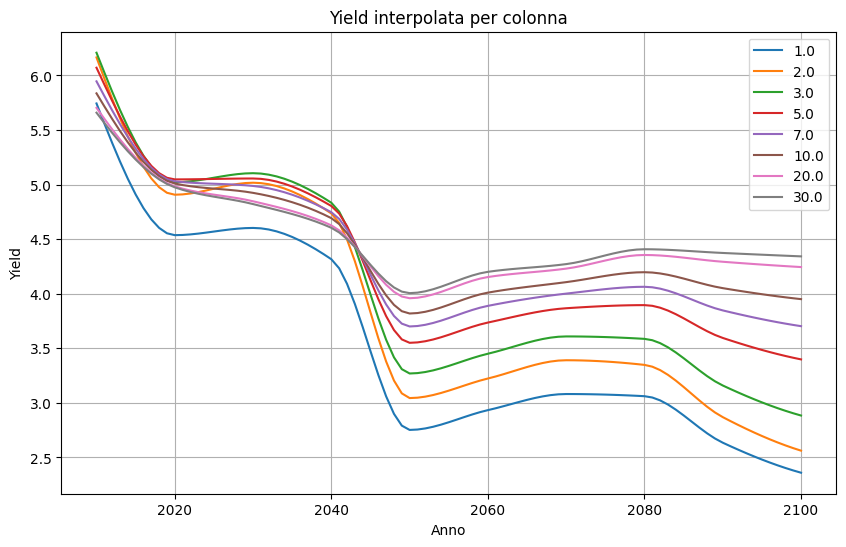

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for col in df_interp_phi.columns:
    plt.plot(df_interp_phi.index, df_interp_phi[col], label=col)

plt.legend()
plt.xlabel("Anno")
plt.ylabel("Yield")
plt.title("Yield interpolata per colonna")
plt.grid(True)
plt.show()


In [33]:
pca = PCA(n_components=1)
yield_ssp5_pca = pca.fit_transform(df_interp_phi[['1.0','2.0','3.0','5.0','7.0','10.0','20.0','30.0']].values)

In [34]:
pca.explained_variance_ratio_

array([0.98517708])